In [1]:
# import necessary packages used for objective steps 4 and 5.
import pandas as pd, numpy as np, scipy, lightgbm as lgb
import matplotlib as matplot
import matplotlib.pyplot as plot
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics import tsaplots as statmodel_plot
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
#from numpy import cov
from sklearn import ensemble
from scipy.stats import uniform
from math import sqrt

## Setting Seaborn Styles
sns.set(style="whitegrid")
sns.set_palette((sns.color_palette('colorblind', 8)))
sns.set(rc = {'figure.figsize':(15,8)})

dims = (20, 10)
%matplotlib inline

## Setting random seed
np.random.seed(1000)



# **IST 718 - Big Data Analytics**

# ***Final Project***
------------------------

Professor Lando


Brett Bastianelli, Alex Geiger,  Maria Ng,  Sam White

## Table of Contents
* [Read In Data](#Read-In-Data)
* [Data Exploration](#Data-Exploration)
    * [States with low graduation rates](#States-with-low-graduation-rates)
* [Baseline Models](#Basic-Models)
* [Final Analysis Advanced Modeling](#Final-Analysis-Advanced-Modeling)
    * [Feature Engineering](#Feature-Engineering)
    * [Data Cleaning](#Data-Cleaning)
    * [Model Training and KFold Validation](#Model-Training-and-KFold-Validation)
    * [Modeling Results](#Modeling-Results)
    * [LGBM Feature Importance](#LGBM-Feature-Importance)
* [Recommendation Introduction](#Recommendation-Introduction)
    * [Methodology](#Methodology)
    * [Results](#Results)
* [Tract Information Stats](#Tract-Information-Stats)

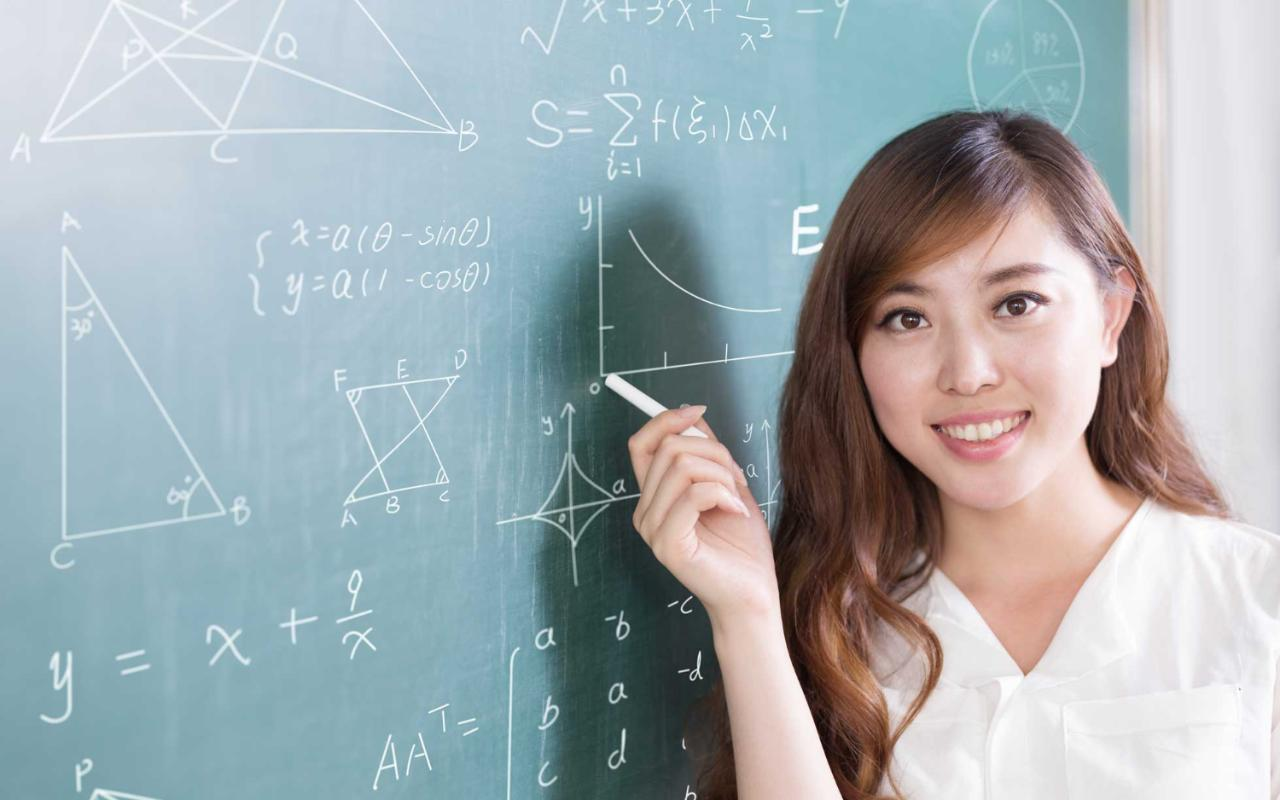

# Introduction

One of the biggest responsibilities of a government is to collect and organize data on their citizens to make the most responsible and informed decisions. The data that our group will be using is the census data from 2018 with key data points such as unemployment, graduation rate, marital status, and median income. All these key metrics, along with the other additional columns, allow for our group to act as a government organization observing the longstanding effects of divorce and high school graduation have on the general population. These findings can help provide educational programs and relief systems to struggling families, so actions, such as divorce, do not hinder their education.

# Read In Data

In [2]:
# defines the path to the root folder the data resides
PathToData = ""

## Census Data Overview

* hi_median_df = household median income
* Unemployed = unemployment KPI
* hs_degree = high school graduation rate
* hs_degree_male = male high school graduation rate
* divorced = percent of people divorced
* m_age_median = male median age
* f_age_median = female median age
* m_divorced = male divorce kpi
* f_divorced = female divorce kpi
* rent_mean = mean cost of rent
* rent_median = median cost of rent
* family_mean = family mean income
* hc_mortgage_mean = mean mortgage housing costs
* second_mortgage = percent of people who have a second mortgage
* home_equity = percent of people with a home equity loan
* not_labor_force = percent of people not in the work force
* pop = total population
* male_pop = male population
* female_pop = female population



In [3]:
df_c = pd.read_csv(PathToData + "census_data.csv",encoding='latin1').fillna(0)
df_census = df_c.rename(columns = {"MZIP":"zipcode"})
df_census.head()

ï»¿STUSAB  SUMLEVEL  STATE_Code  COUNTY_Code state       ALand  AWater  \
0        AL       140           1            1    AL   9809938.0   36312   
1        AL       140           1            1    AL   3341886.0    5968   
2        AL       140           1            1    AL   5349273.0    9054   
3        AL       140           1            1    AL   6382707.0   16244   
4        AL       140           1            1    AL  11399989.0   46159   

         lat        lng       NCESSCH  ...  hc_mortgage_median    hc_mean  \
0  32.481959 -86.491338  1.002400e+10  ...              1223.0  376.00570   
1  32.475758 -86.472468  1.002400e+10  ...              1082.0  294.05753   
2  32.474024 -86.459703  1.002400e+10  ...               969.0  368.10909   
3  32.471030 -86.444835  1.002400e+10  ...              1005.0  370.96556   
4  32.458922 -86.421826  1.002400e+10  ...              1251.0  395.37914   

  hc_median home_equity_second_mortgage  second_mortgage  home_equity  \
0     354.0                     0.01381          0.01381      0.08481   
1     295.0                     0.01617          0.01617      0.09238   
2     364.0                     0.04106          0.04106      0.11111   
3     367.0                     0.05428          0.05428      0.10037   
4     353.0                     0.07228          0.07228      0.14989   

      debt  hs_degree  hs_degree_male  hs_degree_female  
0  0.61144    0.85197         0.78425           0.91199  
1  0.62356    0.74517         0.64943           0.82134  
2  0.62681    0.89344         0.90817           0.88230  
3  0.62602    0.88306         0.90235           0.86497  
4  0.70244    0.95555         0.95578           0.95539  

[5 rows x 49 columns]

In [4]:
df_i = pd.read_csv(PathToData + "2018tax.csv").fillna(0)
df_i.head()

STATEFIPS STATE  zipcode  agi_stub      N1   mars1   MARS2   MARS4     ELF  \
0          1    AL        0         1  768120  466830   90960  198750  696930   
1          1    AL        0         2  503430  225110  130060  134320  457510   
2          1    AL        0         3  274590   95560  131770   41020  248630   
3          1    AL        0         4  174830   35560  123370   12700  159190   
4          1    AL        0         5  245150   25990  207950    6480  224280   

   CPREP  ...  N85300  A85300  N11901  A11901  N11900   A11900  N11902  \
0  37470  ...       0       0   59030   50007  669420  1732176  666750   
1  23180  ...       0       0   77300  111047  424280  1230668  420960   
2  13210  ...       0       0   68920  148870  205830   562490  201770   
3   6830  ...       0       0   47730  136776  126560   403410  122610   
4  10500  ...      50      58   98980  446992  145780   598498  137120   

    A11902  N12000  A12000  
0  1725286    2730    4220  
1  1220934    4110    9399  
2   550675    5790   15182  
3   388967    3730   13784  
4   521691    9850   65917  

[5 rows x 153 columns]

In [5]:
df_irs = df_i
del df_irs['N00200']
del df_irs['N00300']
del df_irs['N00600']
del df_irs['N00650']
del df_irs['N00700']
del df_irs['N00900']
del df_irs['N01000']
del df_irs['N01750']
del df_irs['N02300']
del df_irs['N02500']
del df_irs['N02900']
del df_irs['N02650']
del df_irs['N03150']
del df_irs['N03210']
del df_irs['N03220']
del df_irs['N03270']
del df_irs['N03300']
del df_irs['N04100']
del df_irs['N04200']
del df_irs['N04450']
del df_irs['N04470']
del df_irs['N04475']
del df_irs['N04800']
del df_irs['N05780']
del df_irs['N05800']
del df_irs['N06500']
del df_irs['N07100']
del df_irs['N07180']
del df_irs['N07225']
del df_irs['N07230']
del df_irs['N07240']
del df_irs['N07260']
del df_irs['N07300']
del df_irs['N09400']
del df_irs['N09600']
del df_irs['N09750']
del df_irs['N10300']
del df_irs['N10600']
del df_irs['N10960']
del df_irs['N11070']
del df_irs['N11560']
del df_irs['N11900']
del df_irs['N11901']
del df_irs['N11902']
del df_irs['N12000']
del df_irs['N17000']
del df_irs['N18300']
del df_irs['N18425']
del df_irs['N18450']
del df_irs['N18460']
del df_irs['N18500']
del df_irs['N18800']
del df_irs['N19300']
del df_irs['N19500']
del df_irs['N19530']
del df_irs['N19570']
del df_irs['N19700']
del df_irs['N20950']
del df_irs['N26270']
del df_irs['N59660']
del df_irs['N59720']
del df_irs['N85300']
del df_irs['N85530']
del df_irs['N85770']
del df_irs['N85775']


In [6]:
df_irs.head()

STATEFIPS STATE  zipcode  agi_stub      N1   mars1   MARS2   MARS4     ELF  \
0          1    AL        0         1  768120  466830   90960  198750  696930   
1          1    AL        0         2  503430  225110  130060  134320  457510   
2          1    AL        0         3  274590   95560  131770   41020  248630   
3          1    AL        0         4  174830   35560  123370   12700  159190   
4          1    AL        0         5  245150   25990  207950    6480  224280   

   CPREP  ...  A10960  A11560   A06500   A10300  A85530  A85300  A11901  \
0  37470  ...   42649   12495   112117   272245       0       0   50007   
1  23180  ...   25862    6244   725087   834109       0       0  111047   
2  13210  ...   13663     228  1091252  1178827       0       0  148870   
3   6830  ...    9731       0  1176057  1250551       0       0  136776   
4  10500  ...   17235       0  3655165  3827935     161      58  446992   

    A11900   A11902  A12000  
0  1732176  1725286    4220  
1  1230668  1220934    9399  
2   562490   550675   15182  
3   403410   388967   13784  
4   598498   521691   65917  

[5 rows x 88 columns]

In [7]:
df = pd.merge(df_irs.groupby(["STATE","zipcode"]).mean().reset_index(), df_census, on = 'zipcode', how="right")

In [8]:
#make sure each row represents one zipcode. Take the median of all duplicates
df = df.groupby(["STATE",'zipcode']).median()
df = df.reset_index()
df.head()

STATE  zipcode  STATEFIPS  agi_stub           N1        mars1  MARS2  \
0    AK    99501        2.0       3.5  1281.666667   816.666667  275.0   
1    AK    99502        2.0       3.5  1976.666667  1025.000000  675.0   
2    AK    99503        2.0       3.5  1251.666667   771.666667  285.0   
3    AK    99504        2.0       3.5  3240.000000  1670.000000  990.0   
4    AK    99505        2.0       3.5   380.000000   201.666667  150.0   

        MARS4          ELF       CPREP  ...  hc_mortgage_median     hc_mean  \
0  153.333333  1105.000000   95.000000  ...              2359.0  713.030280   
1  231.666667  1720.000000  146.666667  ...              1877.0  663.201950   
2  160.000000  1091.666667   78.333333  ...              1604.5  657.668905   
3  480.000000  2896.666667  181.666667  ...              1816.0  667.733150   
4   13.333333   366.666667    5.000000  ...                 0.0  525.891010   

   hc_median  home_equity_second_mortgage  second_mortgage  home_equity  \
0      697.0                     0.008820          0.00882      0.04469   
1      647.0                     0.000000          0.00451      0.06954   
2      698.0                     0.019485          0.05785      0.03866   
3      648.0                     0.028970          0.02897      0.08514   
4      810.0                     0.000000          0.00000      0.00000   

      debt  hs_degree  hs_degree_male  hs_degree_female  
0  0.63386    0.88817        0.893120          0.900560  
1  0.75145    0.94469        0.961770          0.929630  
2  0.69448    0.87384        0.859725          0.889925  
3  0.74685    0.94203        0.943640          0.940790  
4  0.00000    0.99097        0.996610          0.984080  

[5 rows x 129 columns]

In [9]:
len(df)

18333

In [10]:
df = df.rename(columns = {"A18800":"property_tax"})

In [11]:
#download data to see lottery revenue by state https://www.taxpolicycenter.org/statistics/lottery-revenue
df_l = pd.read_csv(PathToData + "Lottery.csv").fillna(0)
df_l = df_l.rename(columns = {"2018":"lottery_2018"})
df_l = df_l.rename(columns = {"2019":"lottery_2019"})
df_l.head()

STATE  1977   1982    1987    1992    1997     2002     2004     2005  \
0    AL     0      0       0       0       0        0        0        0   
1    AK     0      0       0       0       0        0        0        0   
2    AZ     0  62702   69962  114119  102555   114633   141779   150758   
3    AR     0      0       0       0       0        0        0        0   
4    CA     0      0  686573  608115  897936  1195797  1202450  1305890   

      2006  ...       2010       2011     2012     2013     2014     2015  \
0        0  ...        0.0        0.0        0        0        0        0   
1        0  ...        0.0        0.0        0        0        0        0   
2   178408  ...   181391.0   183799.0   206171   219710   218316   212331   
3        0  ...   114393.0   130346.0   131548   122437   112077   104943   
4  1400585  ...  1215453.0  1300219.0  1515355  1793779  1952285  2023105   

      2016     2017  lottery_2018  lottery_2019  
0        0        0             0             0  
1        0        0             0             0  
2   204323   243769        266891        297150  
3   120948   117397        157813        165617  
4  2319806  2270015       2489212       2672458  

[5 rows x 23 columns]

In [12]:
df_1 = df_i.groupby(['STATE']).median()
df_1 = df_i.reset_index()
df_1.head()

index  STATEFIPS STATE  zipcode  agi_stub      N1   mars1   MARS2   MARS4  \
0      0          1    AL        0         1  768120  466830   90960  198750   
1      1          1    AL        0         2  503430  225110  130060  134320   
2      2          1    AL        0         3  274590   95560  131770   41020   
3      3          1    AL        0         4  174830   35560  123370   12700   
4      4          1    AL        0         5  245150   25990  207950    6480   

      ELF  ...  A10960  A11560   A06500   A10300  A85530  A85300  A11901  \
0  696930  ...   42649   12495   112117   272245       0       0   50007   
1  457510  ...   25862    6244   725087   834109       0       0  111047   
2  248630  ...   13663     228  1091252  1178827       0       0  148870   
3  159190  ...    9731       0  1176057  1250551       0       0  136776   
4  224280  ...   17235       0  3655165  3827935     161      58  446992   

    A11900   A11902  A12000  
0  1732176  1725286    4220  
1  1230668  1220934    9399  
2   562490   550675   15182  
3   403410   388967   13784  
4   598498   521691   65917  

[5 rows x 89 columns]

In [13]:
#dataframe for census+irs+lottery 
df_pt_lottery = pd.merge(df_1, df_l, on = 'STATE')
df_pt_lottery = df_pt_lottery.rename(columns = {"A18800":"property_tax"})

df_census = df_c.rename(columns = {"state":"STATE"})
df2 = df_census.groupby(['STATE']).median()
df2 = df2.reset_index()

df3 = pd.merge(df2, df_pt_lottery, on = 'STATE', how="right")
df3.head()

STATE  SUMLEVEL  STATE_Code  COUNTY_Code       ALand    AWater        lat  \
0    AL     140.0         1.0         81.0  30518187.0  220040.0  33.259835   
1    AL     140.0         1.0         81.0  30518187.0  220040.0  33.259835   
2    AL     140.0         1.0         81.0  30518187.0  220040.0  33.259835   
3    AL     140.0         1.0         81.0  30518187.0  220040.0  33.259835   
4    AL     140.0         1.0         81.0  30518187.0  220040.0  33.259835   

         lng       NCESSCH   GEOID  ...  2010  2011  2012  2013  2014  2015  \
0 -86.750614  1.018000e+10  1199.0  ...   0.0   0.0     0     0     0     0   
1 -86.750614  1.018000e+10  1199.0  ...   0.0   0.0     0     0     0     0   
2 -86.750614  1.018000e+10  1199.0  ...   0.0   0.0     0     0     0     0   
3 -86.750614  1.018000e+10  1199.0  ...   0.0   0.0     0     0     0     0   
4 -86.750614  1.018000e+10  1199.0  ...   0.0   0.0     0     0     0     0   

   2016  2017  lottery_2018  lottery_2019  
0     0     0             0             0  
1     0     0             0             0  
2     0     0             0             0  
3     0     0             0             0  
4     0     0             0             0  

[5 rows x 153 columns]

# Data Exploration



In [14]:
sns.set(rc = {'figure.figsize':(15,8)})


array([[<AxesSubplot:title={'center':'hs_degree'}>]], dtype=object)

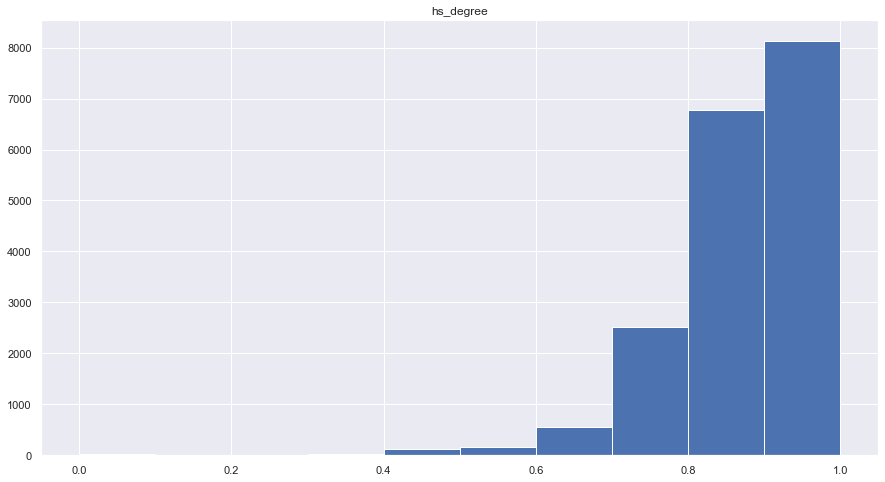

In [15]:
#understand the distribution of high school degree rates
df.hist(column='hs_degree')

<AxesSubplot:>

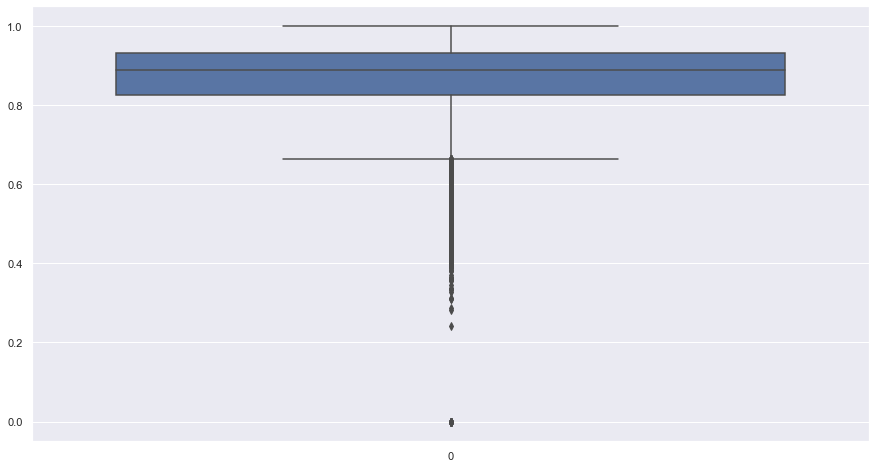

In [16]:
sns.boxplot(data=df['hs_degree'])

array([[<AxesSubplot:title={'center':'property_tax'}>]], dtype=object)

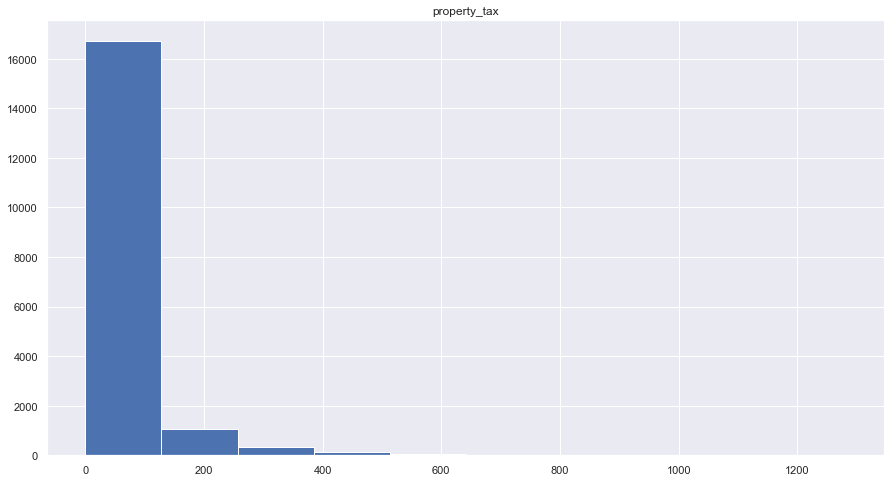

In [17]:
df.hist(column = 'property_tax')

shows a boxplot representing the distribution for our variable of interest, high school
degree rate. We can see that the median falls around 0.9. The distribution is left skewed with
many outliers below 0.6. We do not want to remove these outliers since they are essential to
understanding what contributes to low high school degree rates. 

<AxesSubplot:>

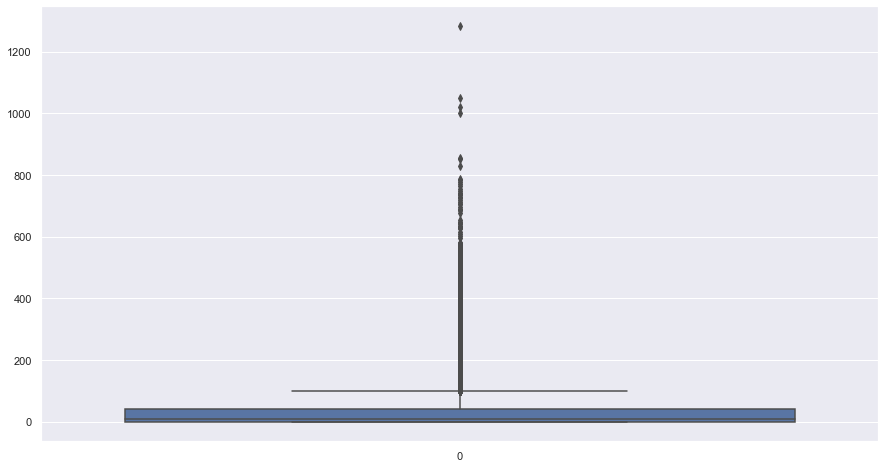

In [18]:
sns.boxplot(data=df['property_tax'])

<AxesSubplot:xlabel='STATE', ylabel='lottery_2018'>

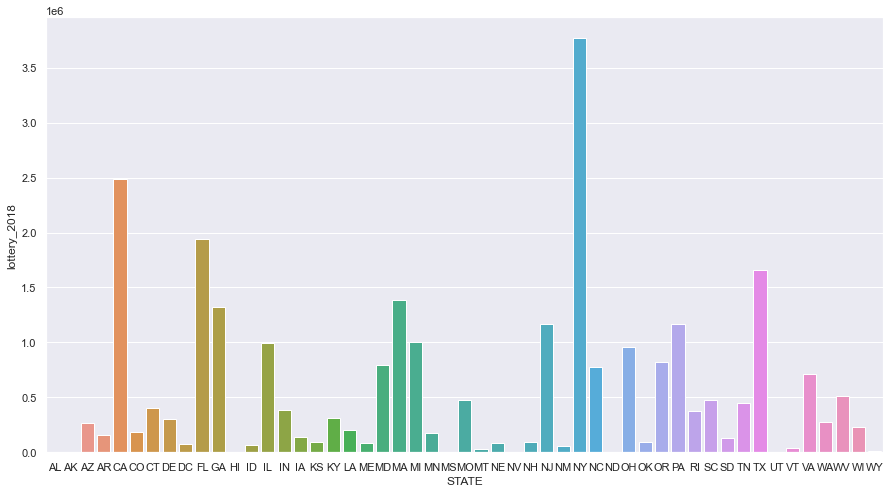

In [19]:
#Lottery Revenue by STATE in 2018 (million)-top four states NY, CA, TX, and FL
sns.barplot(x ='STATE', y = 'lottery_2018', data = df_pt_lottery)

<AxesSubplot:xlabel='STATE', ylabel='property_tax'>

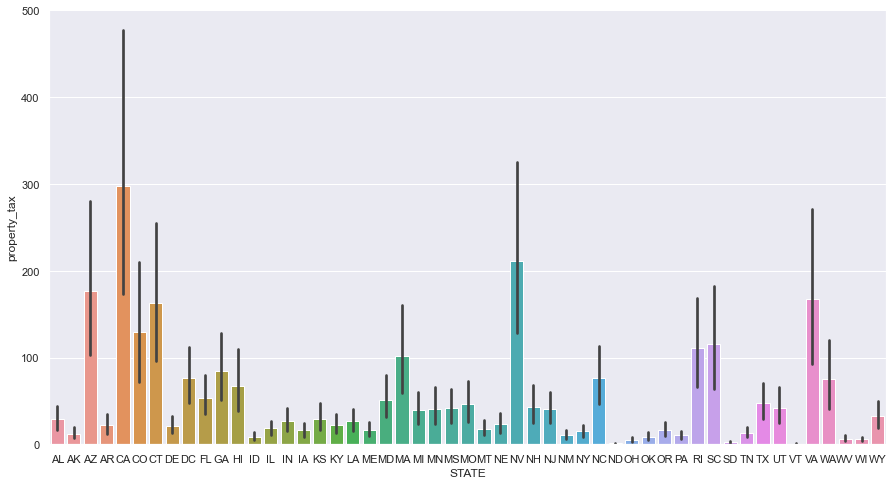

In [20]:
sns.barplot(x ='STATE', y = 'property_tax', data = df_pt_lottery)

## States with low graduation rates

When diving deeper into the zip-codes with a high school degree rate under 0.6, we see that
California, Hawaii, Rhode Island and Texas have the highest number of zip-codes normalized by
population that fall into that category.

(0.0, 0.1)

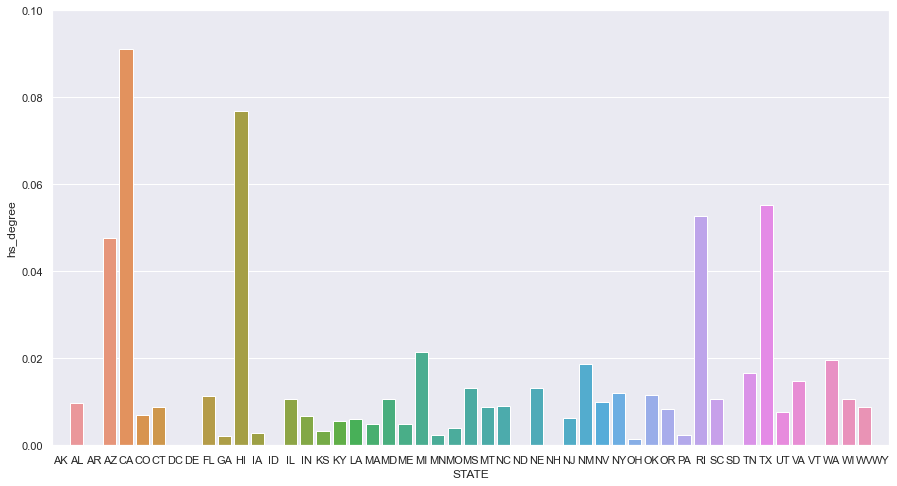

In [21]:
#as we can see there are a bunch of outliers on the bottom. 
#which states have the most zip codes below 0.6?
low_outliers = df[(df['hs_degree']<=0.6) & (df['hs_degree'] > 0)]
low_outliers_by_state = low_outliers.groupby('STATE')['hs_degree'].count()/df.groupby('STATE')['hs_degree'].count()
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x=low_outliers_by_state.index, y=low_outliers_by_state)
plt.ylim(0, 0.1)

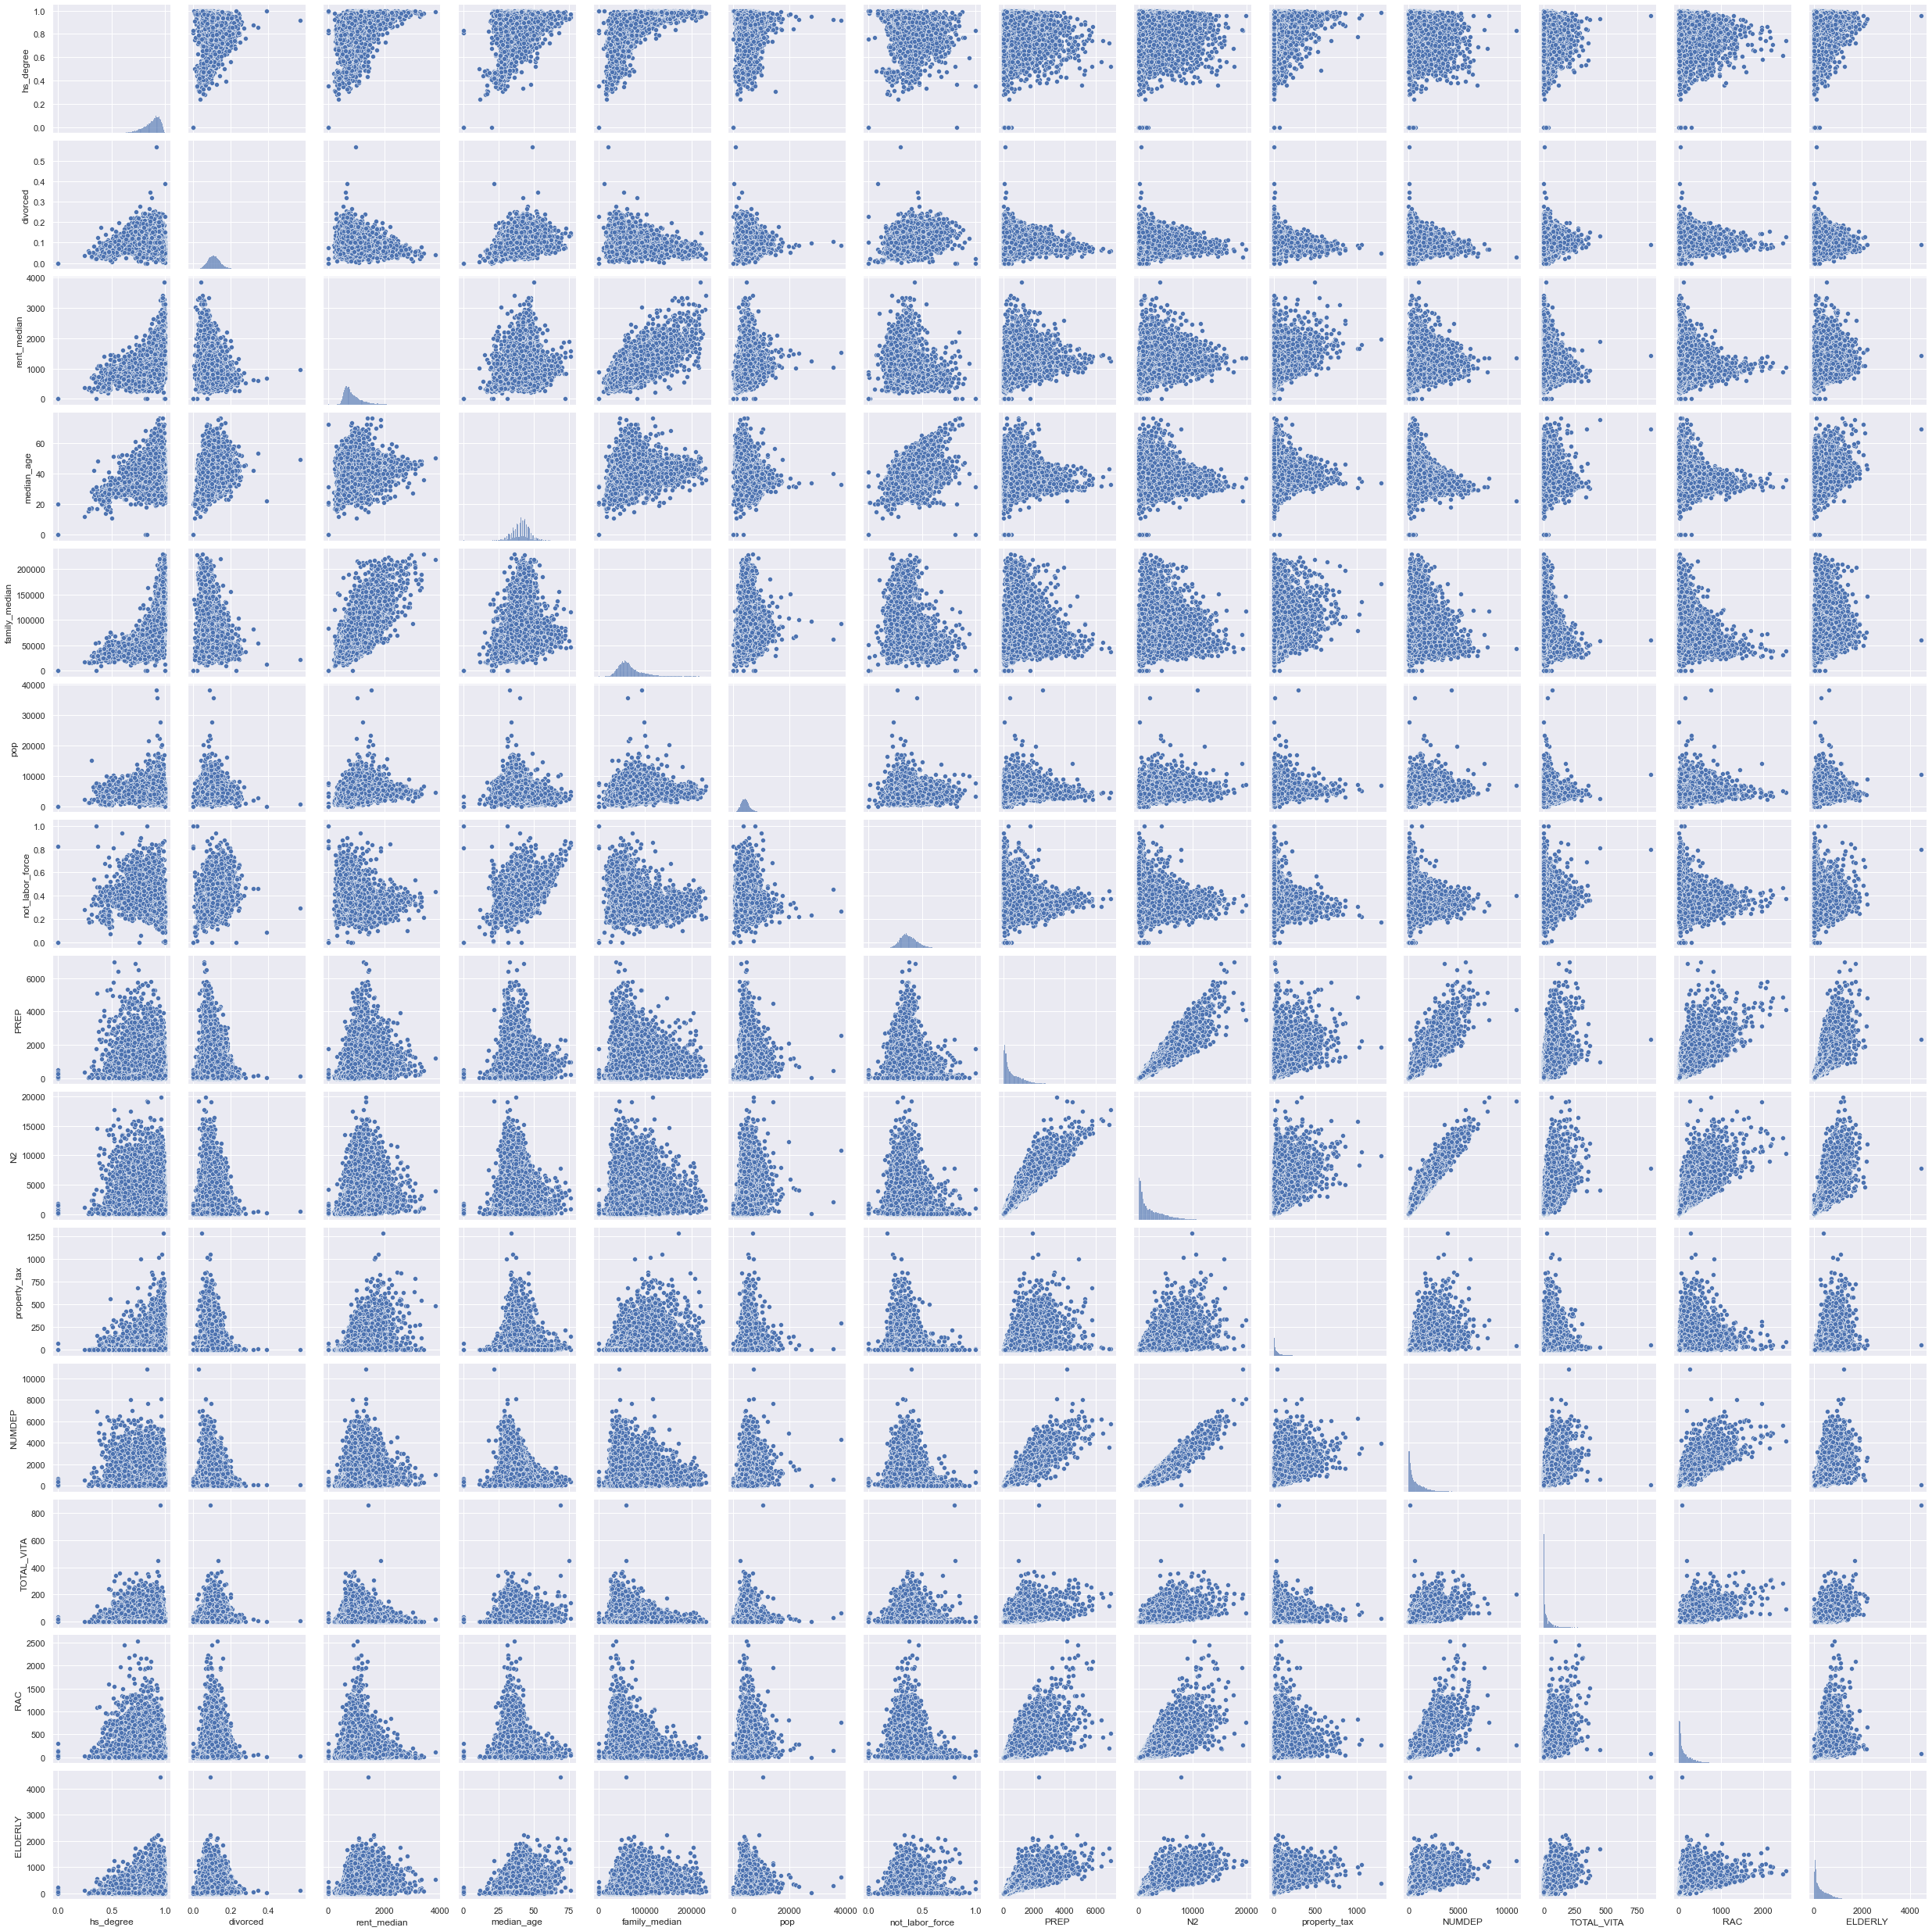

In [22]:
#look at pairplot of variables of interest
sns.pairplot(data=df[['hs_degree','divorced','rent_median','median_age', 'family_median', 
                      'pop', 'not_labor_force','PREP', 'N2', 'property_tax', 'NUMDEP', 'TOTAL_VITA', 'RAC', 'ELDERLY']])

The following figure shows us shows us the correlation between each of the desired variables for the model. We can
see that rent, age, family size, and elderly have the highest correlations with high school degree.
We can also see that “prep”, “n2”, “numdep”, “total vita”, “pac” and “elderly” are highly
correlated with each other, which means that we can only accept one in the model. Since
“elderly” has the highest correlation with high school degree, we will use it in the model.

<AxesSubplot:>

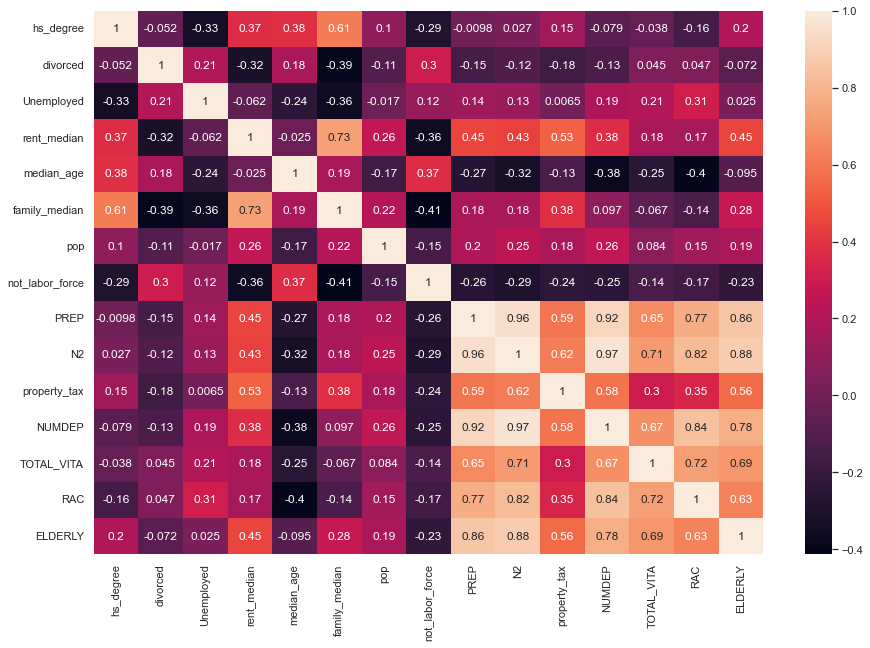

In [23]:
sns.set(rc={"figure.figsize":(15,10)})
sns.heatmap(data=df[['hs_degree','divorced', 'Unemployed','rent_median','median_age', 'family_median', 'pop', 'not_labor_force',
                          'PREP', 'N2', 'property_tax', 'NUMDEP', 'TOTAL_VITA', 'RAC', 'ELDERLY']].corr(), annot = True)

The following figure shows us the correlation with added variables, property tax and lottery. We can see
that there is no strong correlation between high school graduation rates.

<AxesSubplot:>

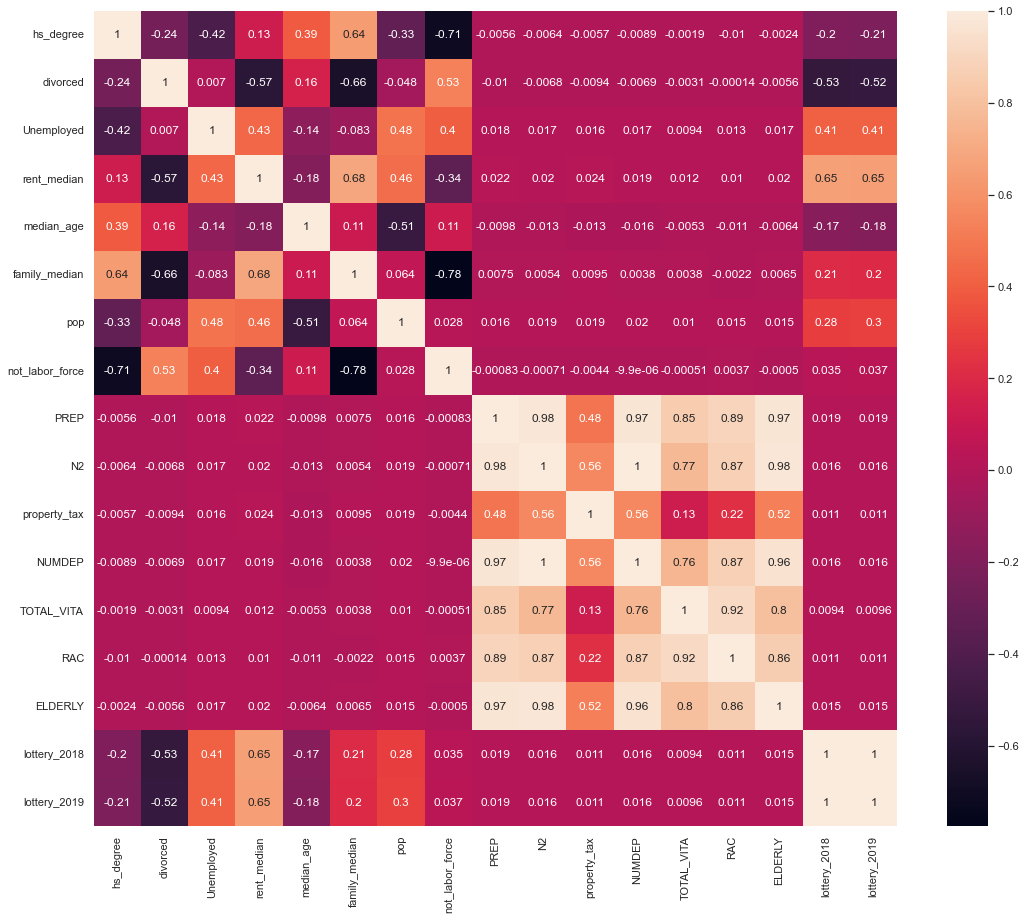

In [24]:
#Looking at the whole USA with property_tax and lottery
sns.set(rc={"figure.figsize":(18,15)})
sns.heatmap(data=df3[['hs_degree','divorced', 'Unemployed','rent_median','median_age', 'family_median', 'pop', 'not_labor_force',
                          'PREP', 'N2', 'property_tax', 'NUMDEP', 'TOTAL_VITA', 'RAC', 'ELDERLY', 'lottery_2018', 'lottery_2019']].corr(), annot = True)

# Baseline Models
Three models were used to predict the high school graduation rate of a zip-code. The first was
an OLS regression model that took the following input variables: divorced, median age, family median,
population, state, not labor force and elderly. To produce a more accurate model, the high school
degree variable was squared. The model resulted in an Adjusted R-squared of 0.623.
The random forest model used all numeric input variables to predict the high school degree
rate. The random forest model had a RMSE of 0.00047
One model was generated to predict the high graduation rate using dataset group by state. The
OLS regression model was constructed based on the following variables: divorce, median age, not labor
force, unemployed and property tax. The model resulted with an adjusted R-square of 0.746 with
property tax was not significant with a p-value of 0.196.


In [25]:
#square the y variable to find better relationships
df['hs_degree_squared'] = df['hs_degree']**2

In [26]:
#train test split
df['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(df))
df_train = df[df['runiform'] >= 0.33]
df_test = df[df['runiform'] < 0.33]

In [27]:
#ols regression model

my_model = str('hs_degree_squared ~ divorced + median_age + family_median + pop + STATE + not_labor_force + ELDERLY')

train_model_fit = smf.ols(my_model, data = df_train).fit()
print(train_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:      hs_degree_squared   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     357.9
Date:                Wed, 21 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:57:35   Log-Likelihood:                 12008.
No. Observations:               12321   AIC:                        -2.390e+04
Df Residuals:                   12264   BIC:                        -2.348e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3973      0.019     

In [28]:
#Lottery and property tax have no impact on hs_degree
df3['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(df3))
df3_train = df3[df3['runiform'] >= 0.33]
df3_test = df3[df3['runiform'] < 0.33]

df_pt_lottery_model = str('hs_degree ~ divorced + median_age + not_labor_force + Unemployed + property_tax')

train_model_fit = smf.ols(df_pt_lottery_model, data = df3).fit()
print(train_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              hs_degree   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                 9.723e+04
Date:                Wed, 21 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:57:36   Log-Likelihood:             4.4979e+05
No. Observations:              165935   AIC:                        -8.996e+05
Df Residuals:                  165929   BIC:                        -8.995e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.8822      0.001   10

In [29]:
#random forest model

#new train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['hs_degree',"hs_degree_male", "hs_degree_female",'hs_degree_squared'],axis=1), df['hs_degree'], test_size=0.2)

In [30]:
#random forest model

from sklearn.preprocessing import StandardScaler

#scale the dataset -- remove none numeric variables since RF can't use them
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train.drop('STATE',axis=1))
X_test_sc = sc.transform(X_test.drop('STATE',axis=1))

In [31]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20)
regressor.fit(X_train_sc, y_train)
y_pred = regressor.predict(X_test_sc)

In [32]:
from sklearn import metrics
import numpy as np

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 8.960437687482653e-05
Mean Squared Error: 3.3549869996761636e-06
Root Mean Squared Error: 0.0018316623596274953


# **Final Analysis Advanced Modeling**
The advanced modeling section utilized the Microsoft LGBM models to predict the high school graduation rate of a particular tract. Census tracts instead of zip codes were used in the advanced modeling section because they are smaller than zip codes. On average, every zip code has 3.792 unique census tract. The zip code which has the highest number of census tracts is Costa Mesa in California which is located right outside of Long Beach California.  In total there are 43 unique tracts located inside of Costa Mesa. 

In [33]:
# import the census data and change the name of zip code
census_df = pd.read_csv(PathToData + 'census_data.csv')
census_df.rename(columns = {"MZIP":"zipcode"}, inplace = True)

# read in the irs data and pre-process the data
irs_df = pd.read_csv(PathToData + "2018tax.csv").fillna(0)
irs_df.rename(columns = {"A18800":"property_tax"},inplace=True)

# merge the censuws and the irs data
df_main = census_df.merge(
            irs_df.groupby("zipcode")[["property_tax"]].median().reset_index(),
            on = "zipcode",
            how="left")

##  Feature Engineering
Here we added a few more features to the dataset. The four new features are the percent of land which is the total land area divided by the total area of the tract. Next is the population density which is calcuated by dividing the number of people in the tract by the total land area. Next the rent to income ration is created by dividing the median rent by the median house hold income. Lastly

In [34]:
df_main["percent_land"] = df_main["ALand"]/df_main[["ALand","AWater"]].sum(axis=1)
df_main["pop_density"] = df_main["pop"]/df_main["ALand"]
df_main["rent_to_income_ratio"] = df_main["rent_median"]/df_main["hi_median_df"]

## Data Cleaning
In short, if we are missing any of our features or our target variable it will be removed from the training dataset.

In [35]:
feature_cols = ["percent_land","pop_density","rent_to_income_ratio",
                "median_age","m_divorced","debt","home_equity","pop",
                "not_labor_force","Unemployed","divorced","pct_own",
                "family_median","property_tax","home_equity_second_mortgage",
                "rent_median","hi_mean"]

target_col = "hs_degree"


# fill the property tax missing data with the median value
#for colName in feature_cols:
#    df_main[colName] = df_main[colName].fillna(df_main[colName].median())

print(df_main.shape)
## Lets just drop the rows where data is missing
df_main = df_main.loc[(df_main[target_col] > 0.01) & (0==df_main[feature_cols].isna().sum(axis=1))].reset_index(drop=True)
print(df_main.shape)

(74001, 53)
(70027, 53)


## Model Training and KFold Validation
The model validation technique was K-Fold cross validation. K-Fold cross validation is when the data is separated into equally sized segments called folds. After, one of the n folds is held and used for testing while the other n-1 folds are used for training. In total n models are iteratively trained and saved to a model's data structure. The reason K-Fold cross validation was utilized instead of a train test split was to ensure all the data was used for validation.

In [36]:
kf = KFold(n_splits=5, random_state=1234, shuffle=True)
fold_n = 0
models = []
modelEval = pd.DataFrame()
modelFeatures = pd.DataFrame()

# create the feature to process
for tr_idx, te_idx in kf.split(df_main[feature_cols],df_main[target_col]):

    # add one to the folds
    fold_n += 1

    # create the train and test variables here for the model
    X_train, y_train = df_main.loc[tr_idx,feature_cols], df_main.loc[tr_idx,target_col]
    X_test, y_test = df_main.loc[te_idx,feature_cols], df_main.loc[te_idx,target_col]

    # setup the model object
    model_lgb = lgb.LGBMRegressor(colsample_bytree=0.95,learning_rate=0.005, max_depth=63,
                min_child_weight=1, min_split_gain=0.2, n_estimators=2000,
                num_leaves=255,
                subsample=0.6)

    # fit the model
    models.append(model_lgb.fit(X_train, 
                      y_train,
                      eval_set = [(X_train, y_train), (X_test, y_test)],
                      eval_metric ='rmse',
                      early_stopping_rounds = 400,
                      verbose =500))

    # generate the predictions
    train_preds = models[-1].predict(X_train)
    test_preds = models[-1].predict(X_test)

    tempFeatures = pd.DataFrame(dict(score = models[-1].feature_importances_, features = X_train.columns))
    tempFeatures["fold"] = fold_n
    modelFeatures = pd.concat([modelFeatures, tempFeatures],sort=False)

    # loop through the types of data
    for datatype, actual, pred in [("train",y_train,train_preds),
                                 ("test",y_test,test_preds)]:
        # save model results
        tempModelEval = dict(data=[datatype],fold=[fold_n])
        tempModelEval["mae"] = [mean_absolute_error(actual,pred)]
        tempModelEval["mape"] = [mean_absolute_percentage_error(actual,pred)]
        tempModelEval["rmse"] = [mean_squared_error(actual,pred, squared=False)]

        # add to the model evaluation dataset
        modelEval = pd.concat([modelEval,pd.DataFrame(tempModelEval)],sort=False)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	training's rmse: 0.0622603	training's l2: 0.00387635	valid_1's rmse: 0.064155	valid_1's l2: 0.00411587
[1000]	training's rmse: 0.0603527	training's l2: 0.00364245	valid_1's rmse: 0.0625559	valid_1's l2: 0.00391324


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	training's rmse: 0.0619722	training's l2: 0.00384056	valid_1's rmse: 0.0651834	valid_1's l2: 0.00424888
[1000]	training's rmse: 0.0600674	training's l2: 0.0036081	valid_1's rmse: 0.0635244	valid_1's l2: 0.00403535


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	training's rmse: 0.0623273	training's l2: 0.00388469	valid_1's rmse: 0.0631663	valid_1's l2: 0.00398998
[1000]	training's rmse: 0.0603704	training's l2: 0.00364459	valid_1's rmse: 0.0613509	valid_1's l2: 0.00376393


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	training's rmse: 0.0621957	training's l2: 0.0038683	valid_1's rmse: 0.0643702	valid_1's l2: 0.00414353
[1000]	training's rmse: 0.0603001	training's l2: 0.00363611	valid_1's rmse: 0.0625851	valid_1's l2: 0.00391689


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	training's rmse: 0.0621067	training's l2: 0.00385724	valid_1's rmse: 0.064599	valid_1's l2: 0.00417304
[1000]	training's rmse: 0.0602188	training's l2: 0.0036263	valid_1's rmse: 0.0630528	valid_1's l2: 0.00397566


## Modeling Results
In total 5 models were trained one for each of the five folds. Of these five models, each was evaluated using several different metrics. These metrics which were utilized to evaluate the training and testing dataset included mean average error, mean percent error and root mean square error. The average score for each of the five metrics is provided below.  

In [37]:
modelEval.groupby("data").mean()

fold       mae      mape      rmse
data                                     
test    3.0  0.044433  0.058086  0.062614
train   3.0  0.043129  0.056215  0.060262

In [38]:
modelFeatures

score                     features  fold
0     161                 percent_land     1
1    2696                  pop_density     1
2     205         rent_to_income_ratio     1
3    4100                   median_age     1
4     137                   m_divorced     1
..    ...                          ...   ...
12   3245                family_median     5
13   1881                 property_tax     5
14      0  home_equity_second_mortgage     5
15    320                  rent_median     5
16    701                      hi_mean     5

[85 rows x 3 columns]

## LGBM Feature Importance
Every model that had been trained had a unique score for each feature in the model's feature set. Since multiple models had been trained, one for every fold this created a difficult problem for the visualization of the results. Therefore, the seaborn boxplot definition was utilized which statistically encapsulated the multiple values for each features score in a beautiful visual format. 

The visualization speaks to how the leading indicators of the model are the median age followed by the median family income. From the analysis of the data, it is evident that the median age and high school graduation rates are positively correlated. Therefore, as the median age increases the graduation rate increases as well. In addition, the family income is also positively correlated to high school graduation rates. Therefore, as the median income increases so does the high school graduation rate. 

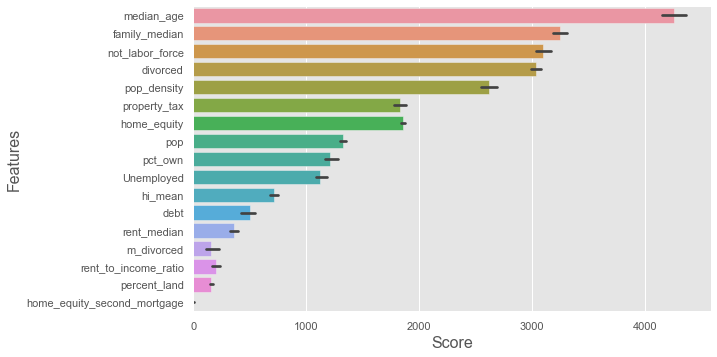

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.style.use('ggplot')

plt.figure(figsize=(10,5))
sns.barplot(x='score', y='features', data=modelFeatures.sort_values(by='score', ascending=False))
plt.tight_layout()
plt.xlabel("Score",fontsize=16)
plt.ylabel("Features",fontsize=16)
plt.show()

## Recommendation Introduction
For the project, the team wanted to go beyond predictive statistics and look to produce recommendations to help struggling communities increase their graduation rates. First, the team needed to identify a specific community struggling with getting students to graduate. The census tract the team had Identified was in Salians City California which had one of the lowest graduation rates in the country coming in at 28%.  


In [40]:
worst_location = df_main.loc[df_main.hs_degree > .05].copy().sort_values("hs_degree").head(10).tail(1)
worst_location.loc[6844]

STUSAB                                      CA
SUMLEVEL                                   140
STATE_Code                                   6
COUNTY_Code                                 53
state                                       CA
ALand                                 511582.0
AWater                                       0
lat                                  36.675888
lng                                -121.632795
NCESSCH                          63393005329.0
GEOID                                     1444
county                         Monterey County
coubsum                            Salinas CCD
place                             Salinas city
zipcode                                  93905
area_code                                  831
MCITY                                  Salinas
pct_own                                 0.0261
median_age                                30.0
divorced                              0.023137
Unemployed                            0.069877
not_labor_for

## Methodology
To inspire recommendations for the struggling community the team augment the features of the community and evaluate the impact of the augmentation on the community using the trained models. For instance, if the community were to increase its family income what impact would that have on high school graduation?  

Specifically, the analysis that was conducted performed bivariate sensitivity analysis to quantify how changing two variables impacted the high school graduation rate. In short, a two-dimensional grid was generated. On the x-axis was variable 1 and, on the y-axis was variable 2. The value of the element corresponding to variable 1 and variable 2 was the high school graduation rate. All other variables or features in the model that were not variable 1 and variable 2 were kept static. 

      family_median  median_age  hs_degree
6844        28563.0        30.0    0.28369


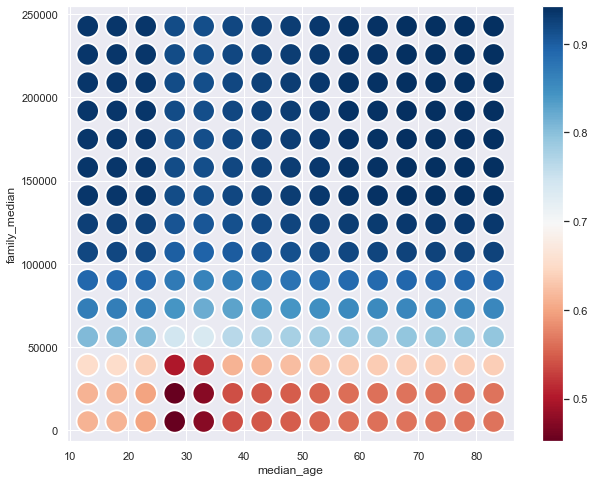

In [41]:
worst_location = df_main.loc[df_main.hs_degree > .05].copy().sort_values("hs_degree").head(10).tail(1)
collected_data = pd.DataFrame()
col_1 = "median_age"
col_2 = "family_median"
print(worst_location[[col_2,col_1,"hs_degree"]])
for col_1_val in np.linspace(df_main[col_1].min(),df_main[col_1].max(),15):
    for col_2_val in np.linspace(df_main[col_2].min(),df_main[col_2].max(),15):
        mdl_input = worst_location[feature_cols].copy()
        mdl_input[col_1] = col_1_val
        mdl_input[col_2] = col_2_val

        mdlPreds = 0
        for mdl in models:
            mdlPreds += mdl.predict(mdl_input)/len(models)

        collected_data = pd.concat([collected_data,
                                    pd.DataFrame({col_1: [col_1_val],
                                                      "size":[2000],
                                                      col_2: [col_2_val], 
                                                      "pred":mdlPreds})])


plt.figure(figsize=(10,8))
sns.set()
ax = sns.scatterplot(data=collected_data, x=col_1, y=col_2, hue="pred", size = "pred", sizes=(500, 500), palette='RdBu')
plt.legend("")

norm = plt.Normalize(collected_data['pred'].min(), collected_data['pred'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

## Results
*The* following vitalization depicts the impact of augmenting the family median income and the median age of residents of Salians City in California. From the analysis the median family income is an important driver of high school graduation rate. Therefore, the team recommends a job-fair to bring high paying jobs to the local area thereby increasing the graduation rate and solving this systemic problem. The job-fair would allow for individuals who may not have completed their education to see the many different career opportunities that are available. A large part of the education and financial disparity in America, at the moment, seems to be the lack of available information. Individuals may not know of what career paths would best fit and take the first paying opportunity to support themselves and their family. This career fair would break that cycle by providing information to what professional endeavors are available and how to apply for them. It appears in this instance that money may just solve the problem, this time. 

Along with the recommendation of a job fair, the opportunity of developing tax incentives leading to a growth in high paying career opportunities in the area also shows promising signs. This recommendation would take more planning as we would be looking to directly influence the government rather than hosting a job fair, but it could lead to positive results for those impacted. If large companies were to receive tax credits by hiring individuals without a high school degree, it would be a mutual benefit. Individuals who were negatively impacted and could not complete their education due to extenuating circumstances such as a parental divorce, would receive a well-paying job that fits their skill set while the global company would receive a tax break at the end of the year. Along with a well-paying job, these individuals who are a part of the tax incentive program could also receive further funding or help with completing their GED to help make them more of a well-rounded employee and open to further advancements within the company.  

## Tract Information Stats

In [42]:
# find the average # of tracts per zip code
df_main["SUMLEVEL"].count()/df_main.zipcode.nunique()

3.8268211377670913

In [43]:
df_main.groupby("zipcode")["SUMLEVEL"].count().sort_values(ascending=False)

zipcode
92626    43
11204    36
11234    35
11236    34
60647    34
         ..
21545     1
21562     1
21623     1
21625     1
63627     1
Name: SUMLEVEL, Length: 18299, dtype: int64